In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import time

curr_directory = os.getcwd()
#
#
#
# Create index for all players + roster dictionaries
#
#
# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))
#
#
#
# Data Processing
#
#
#
# Game data from 2014 - 2015 season to 2017-2018 season
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]
#
#
#
# Game data from the 2018-2019 season and the 2019-2020 season
game_data_2018 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2018_2019.csv'))
game_data_2019 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2019_2020.csv'))

# Strip the day of week abbreviation from Date
game_data_2018['Date'] = game_data_2018['Date'].str[4:]
game_data_2019['Date'] = game_data_2019['Date'].str[4:]

# Date conversion functions
def monthToNum(shortMonth):
    return{
            'Jan' : '01',
            'Feb' : '02',
            'Mar' : '03',
            'Apr' : '04',
            'May' : '05',
            'Jun' : '06',
            'Jul' : '07',
            'Aug' : '08',
            'Sep' : '09', 
            'Oct' : '10',
            'Nov' : '11',
            'Dec' : '12'
    }[shortMonth]

def convert_dates(dataframe): 
    for i in range(dataframe['Date'].shape[0]): 
        if len(dataframe['Date'][i]) == 10: 
            year = dataframe['Date'][i][6:10]
            date = '0' + dataframe['Date'][i][4]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date
        else: 
            year = dataframe['Date'][i][7:11]
            date = dataframe['Date'][i][4:6]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date

convert_dates(game_data_2018)
convert_dates(game_data_2019)

game_results_2018 = np.array(list(game_data_2018['Visitor PTS'] - game_data_2018['Home PTS']))
teams_2018 = np.array(list(zip(game_data_2018.Visitor, game_data_2018.Home)))
dates_2018 = np.array(list(game_data_2018['Date']))

game_results_2019 = np.array(list(game_data_2019['Visitor PTS'] - game_data_2019['Home PTS']))
teams_2019 = np.array(list(zip(game_data_2019.Visitor, game_data_2019.Home)))
dates_2019 = np.array(list(game_data_2019['Date']))
#
#
#
# Combine all data into one dataset
#
#
#
teams_all = np.concatenate((unique_teams, teams_2018, teams_2019), axis=0)
dates_all = np.concatenate((unique_dates, dates_2018, dates_2019), axis=0)
results_all = np.concatenate((unique_game_results, game_results_2018, game_results_2019), axis=0)

In [33]:
class QuadraticRegression:
    def __init__(self, step_size=1e-5, max_iter=200, eps=1e-3, batch_size =32, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.batch_size = batch_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.error_list = []
        self.training_acc = []
        self.dev_acc = []
        
    def getSAS(self):
        # Top left
        S = np.array(self.theta[0:962, 0:962])
        # Bottom right
        S2 = np.array(self.theta[963:1925, 963:1925])
        # Top right
        A = np.array(self.theta[0:962, 963:1925])
        # Bottom left
        A2 = np.array(self.theta[963:1925, 0:962])
        
        return S,S2,A,A2

    def predict(self, x): 
        z = x@self.theta@x.T 
        return self.sigmoid(z)
    
    def sigmoid(self, z): 
        return 1.0 / (1. + np.exp(-z))
    
    def loss_function_t(self, theta_t, x, y):
        EPS = 1e-8
        x = torch.tensor(x)
        y = torch.tensor(y)
        p = torch.sigmoid(x @ theta_t @ x.T)
        return -1.*((y * torch.log(p + EPS) + (1-y) * torch.log(1 - p + EPS)).sum())
    
    def pytorch_gradient(self, x, y):
        theta_t = torch.tensor(self.theta, requires_grad=True)
        self.loss_function_t(theta_t, x, y).backward()
        return theta_t.grad.numpy()
    
    def pytorch_batch_gradient(self, x_teams, y_teams, index): 
        x = x_teams[index::self.batch_size]
        y = y_teams[index::self.batch_size]
        
        theta_t = torch.tensor(self.theta, requires_grad=True)
        self.loss_function_t(theta_t, x, y).backward()
        return theta_t.grad.numpy()
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        theta = np.matrix(self.theta)
        
        for i in range(x_teams.shape[0]):
            x = np.matrix(x_teams[i, :])
            y = np.asscalar(y_teams[i])
            update += x.T@x@theta@x.T@x - y*x.T@x
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        update = 0
        theta = np.matrix(self.theta)
        
        for i in range(batch_size):
            x = np.matrix(x_teams[int((i+index) % x_teams.shape[0]), :])
            y = np.asscalar(y_teams[int((i+index) % x_teams.shape[0])])
            update += x.T@x@theta@x.T@x - y*x.T@x
            
        return update
    
    def fit(self, x, y, dev_x, dev_y, mini = False):
        iterations = 0
        abs_error = 1
        ind = 0
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players, 2*num_players))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1000000:
                error = self.step_size*self.pytorch_gradient(x, y)
                abs_error = np.linalg.norm(error, 2)
                self.error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = self.project(theta_new)

                iterations += 1
                
                train_accuracy = self.training_predict(x, y)
                self.training_acc.append(train_accuracy)
                dev_accuracy = self.training_predict(dev_x, dev_y)
                self.dev_acc.append(dev_accuracy)

                print('Error {}: {}'.format(iterations, abs_error))
                print('Training Accuracy: {}'.format(train_accuracy))
                print('Dev Accuracy: {}'.format(dev_accuracy))
        else:
            batch_num = 1
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1000000:
                error = self.step_size*self.pytorch_batch_gradient(x, y, self.batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                self.error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = self.project(theta_new)

                iterations += 1
                ind += 1

                print('Error {}: {}'.format(iterations, abs_error))
        
        print('Convergence!')
        plt.style.use('seaborn-darkgrid')
        plt.plot(self.training_acc, color = 'firebrick', label='Training Accuracy')
        plt.plot(self.dev_acc, color = 'teal', label='Dev Accuracy')
        plt.legend(loc='lower right')
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.savefig('{}.png'.format(self.step_size), dpi = 300)
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[0, :] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:, 0]
            
        x = x_without_intercept
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y

    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1] + 1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
    
    def symmetrize(self, m):
        m1 = np.array(m)
        m2 = np.array(m).T
        m_out = 0.5*(m1 + m2)
                
        return m_out
    
    def antisymmetrize(self, m):
        m1 = np.array(m)
        m2 = np.array(m).T
        m_out = 0.5*(m1 - m2)
                
        return m_out
    
    def project(self, m):
        m = np.array(m)
        side = m.shape[0]
        S = self.symmetrize(m[0:int(side/2 - 1),0:int(side/2 - 1)])
        S_minus = self.symmetrize(m[int(side/2):int(side-1), int(side/2):int(side-1)])

        A = self.antisymmetrize(m[0:int(side/2-1), int(side/2):int(side-1)])
        A_minus = self.antisymmetrize(m[int(side/2):int(side-1), 0:int(side/2-1)])
        S_new = (S - S_minus)/2
        S_minus_new = (S_minus - S)/2
        
        if np.allclose(A, -1*A_minus, 1e-10, 1e-10):
            A_new = A
            A_minus_new = A_minus
        elif np.linalg.norm(A.T - A_minus, 2) < np.linalg.norm(A - A_minus, 2):
            A_new = 0.5*(A + A_minus)
            A_minus_new = A_new.T
        else:
            A_new = 0.5*(A + A_minus.T)
            A_minus_new = A_new.T
            
        M = np.zeros(m.shape)
        M[0:int(side/2 - 1),0:int(side/2 - 1)] = S_new
        M[int(side/2):int(side-1),int(side/2):int(side - 1)] = S_minus_new
        M[0:int(side/2 - 1),int(side/2):int(side - 1)] = A_new
        M[int(side/2):int(side - 1),0:int(side/2 - 1)] = A_minus_new
        
        return M
    
    def training_predict(self, test_x, test_y): 
        predicted_y = []
        for i in range(test_x.shape[0]):
            x = test_x[i,:]
            prediction = self.predict(x)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        return np.mean(np.array(predicted_y) == np.array(test_y.T))
    
    def general_predict(self, teams, dates, results): 
        test_x, test_y = self.process_data(teams, dates, results)
        
        predicted_y = []
        for i in range(test_x.shape[0]):
            x = test_x[i,:]           
            prediction = self.predict(x)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        return np.mean(np.array(predicted_y) == np.array(test_y.T))
    
    def playoff_prediction(self, playoff_filename, playoff_date): 
        # Load playoff data
        playoff_data = pd.read_csv(os.path.join(curr_directory, playoff_filename))

        # Extract features of interest
        raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
        raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
        raw_playoff_dates = np.array(list(playoff_data['Date']))

        playoff_pairs = {}

        for i in range(len(raw_playoff_team_pairs)): 
            team_1 = raw_playoff_team_pairs[i][0]
            team_2 = raw_playoff_team_pairs[i][1]
            if (team_1,team_2) in playoff_pairs.keys(): 
                # if results > 0 --> team A won --> +1
                # if results < 0 --> team B won --> -1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] += 1
                else: 
                    playoff_pairs[team_1,team_2] += -1
            elif (team_2,team_1) in playoff_pairs.keys():
                # if results > 0 --> team B won --> -1
                # if results < 0 --> team A won --> +1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_2,team_1] += -1
                else: 
                    playoff_pairs[team_2,team_1] += 1
            else: 
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] = 1
                else: 
                    playoff_pairs[team_1,team_2] = -1

        playoff_teams = []
        playoff_results = []
        playoff_dates = []

        for key in playoff_pairs: 
            playoff_teams.append([key[0], key[1]])
            playoff_results.append(playoff_pairs[key])
            playoff_dates.append(playoff_date)

        playoff_teams = np.array(playoff_teams)
        playoff_results = np.array(playoff_results)
        playoff_dates = np.array(playoff_dates)

        playoff_x, playoff_y = self.process_data(playoff_teams, playoff_dates, playoff_results)

        predicted_y = []
        for i in range(playoff_x.shape[0]):
            x = playoff_x[i,:]
            prediction = self.predict(x)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

        return prediction_accuracy

In [3]:
teams_s, dates_s, results_s = shuffle(teams_all, dates_all, results_all, random_state=10)
# 64% training, 16% dev, 20% test
n_train = 4159
n_dev = 5199
n_full = 6500

teams_train = teams_s[0:n_train]
dates_train = dates_s[0:n_train]
results_train = results_s[0:n_train]

teams_dev = teams_s[n_train + 1:n_dev]
dates_dev = dates_s[n_train + 1:n_dev]
results_dev = results_s[n_train + 1:n_dev]

teams_test = teams_s[n_dev + 1:n_full]
dates_test = dates_s[n_dev + 1:n_full]
results_test = results_s[n_dev + 1:n_full]

lr = 2E-6
Error 1: 3.869506717759991
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 2.537564900882034
Training Accuracy: 0.6463092089444578
Dev Accuracy: 0.6198267564966313
Error 3: 3.06727934668115
Training Accuracy: 0.6479923058427507
Dev Accuracy: 0.6217516843118384
Error 4: 2.8723641194043665
Training Accuracy: 0.6633806203414282
Dev Accuracy: 0.6564003849855631
Error 5: 2.693684214616293
Training Accuracy: 0.6751622986294782
Dev Accuracy: 0.6390760346487007
Error 6: 2.453845952050898
Training Accuracy: 0.6761240682856456
Dev Accuracy: 0.6679499518768046
Error 7: 2.507180403556316
Training Accuracy: 0.6787689348401058
Dev Accuracy: 0.6496631376323387
Error 8: 2.4086631509713827
Training Accuracy: 0.6802115893243568
Dev Accuracy: 0.6602502406159769
Error 9: 2.4479481410735007
Training Accuracy: 0.6830968982928589
Dev Accuracy: 0.6535129932627527
Error 10: 2.398465606188082
Training Accuracy: 0.6797307044962732
Dev Accuracy: 0.6592877767083735
Error 1

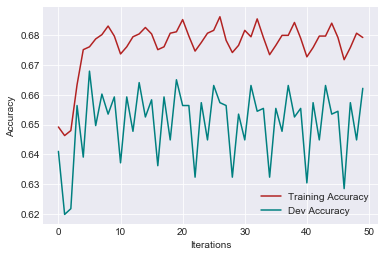

Train Accuracy: 0.6792498196681894
Dev Accuracy: 0.6621751684311838


In [5]:
print('lr = 2E-6')
model_lr_2e6 = QuadraticRegression(step_size = 2e-6, max_iter = 50)
x_lr_2e6, y_lr_2e6= model_lr_2e6.process_data(teams_train, dates_train, results_train)
dev_x_2e6, dev_y_2e6 = model_lr_2e6.process_data(teams_dev, dates_dev, results_dev)
model_lr_2e6.fit(x_lr_2e6, y_lr_2e6, dev_x_2e6, dev_y_2e6)

train_accuracy_2e6 = model_lr_2e6.general_predict(teams_train, dates_train, results_train)
dev_accuracy_2e6 = model_lr_2e6.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_2e6))
print('Dev Accuracy: {}'.format(dev_accuracy_2e6))

np.savetxt('error_lr_2e6.txt', np.array(model_lr_2e6.error_list), delimiter =',')
np.savetxt('training_acc_lr_2e6.txt', np.array(model_lr_2e6.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_2e6.txt', np.array(model_lr_2e6.dev_acc), delimiter =',')

lr = 1E-6
Error 1: 1.9347533588799954
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 1.5072285574969846
Training Accuracy: 0.6660254868958885
Dev Accuracy: 0.6448508180943214
Error 3: 1.351626390269939
Training Accuracy: 0.6739600865592691
Dev Accuracy: 0.6525505293551492
Error 4: 1.233233865310115
Training Accuracy: 0.6737196441452272
Dev Accuracy: 0.6544754571703562
Error 5: 1.2848972235661786
Training Accuracy: 0.677085837941813
Dev Accuracy: 0.6564003849855631
Error 6: 1.222304482135643
Training Accuracy: 0.678528492426064
Dev Accuracy: 0.6573628488931665
Error 7: 1.2509561332698806
Training Accuracy: 0.679971146910315
Dev Accuracy: 0.6602502406159769
Error 8: 1.2152547868327925
Training Accuracy: 0.6826160134647752
Dev Accuracy: 0.6641000962463908
Error 9: 1.2325270614925572
Training Accuracy: 0.6821351286366916
Dev Accuracy: 0.6641000962463908
Error 10: 1.210625161592522
Training Accuracy: 0.6859822072613609
Dev Accuracy: 0.6602502406159769
Error 

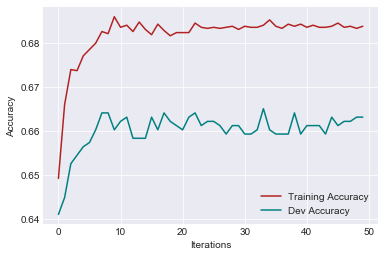

Train Accuracy: 0.6838182255349844
Dev Accuracy: 0.6631376323387873


In [6]:
print('lr = 1E-6')
model_lr_1e6 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_lr_1e6, y_lr_1e6= model_lr_1e6.process_data(teams_train, dates_train, results_train)
dev_x_1e6, dev_y_1e6 = model_lr_1e6.process_data(teams_dev, dates_dev, results_dev)
model_lr_1e6.fit(x_lr_1e6, y_lr_1e6, dev_x_1e6, dev_y_1e6)

train_accuracy_1e6 = model_lr_1e6.general_predict(teams_train, dates_train, results_train)
dev_accuracy_1e6 = model_lr_1e6.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_1e6))
print('Dev Accuracy: {}'.format(dev_accuracy_1e6))

np.savetxt('full_dataset_lr_1e6.txt', np.array(model_lr_1e6.error_list), delimiter =',')
np.savetxt('training_acc_lr_1e6.txt', np.array(model_lr_1e6.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_1e6.txt', np.array(model_lr_1e6.dev_acc), delimiter =',')

lr = 5E-7
Error 1: 0.9673766794399977
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 0.8533949597805006
Training Accuracy: 0.6653041596537629
Dev Accuracy: 0.6458132820019249
Error 3: 0.775524530853648
Training Accuracy: 0.6672276989660976
Dev Accuracy: 0.6458132820019249
Error 4: 0.7259793222915063
Training Accuracy: 0.6713152200048088
Dev Accuracy: 0.6515880654475458
Error 5: 0.693263136104032
Training Accuracy: 0.6720365472469344
Dev Accuracy: 0.6525505293551492
Error 6: 0.6709399514262463
Training Accuracy: 0.6717961048328925
Dev Accuracy: 0.6544754571703562
Error 7: 0.6552732450546929
Training Accuracy: 0.6720365472469344
Dev Accuracy: 0.6573628488931665
Error 8: 0.6440011011207819
Training Accuracy: 0.672517432075018
Dev Accuracy: 0.6564003849855631
Error 9: 0.6357050860779746
Training Accuracy: 0.6768453955277711
Dev Accuracy: 0.6592877767083735
Error 10: 0.6222798054496297
Training Accuracy: 0.6773262803558547
Dev Accuracy: 0.6602502406159769
Er

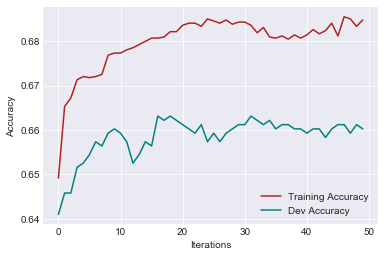

Train Accuracy: 0.6847799951911517
Dev Accuracy: 0.6602502406159769


In [7]:
print('lr = 5E-7')
model_lr_5e7 = QuadraticRegression(step_size = 5e-7, max_iter = 50)
x_lr_5e7, y_lr_5e7= model_lr_5e7.process_data(teams_train, dates_train, results_train)
dev_x_5e7, dev_y_5e7 = model_lr_5e7.process_data(teams_dev, dates_dev, results_dev)
model_lr_5e7.fit(x_lr_5e7, y_lr_5e7, dev_x_5e7, dev_y_5e7)

train_accuracy_5e7 = model_lr_5e7.general_predict(teams_train, dates_train, results_train)
dev_accuracy_5e7 = model_lr_5e7.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_5e7))
print('Dev Accuracy: {}'.format(dev_accuracy_5e7))

np.savetxt('full_dataset_lr_5e7.txt', np.array(model_lr_5e7.error_list), delimiter =',')
np.savetxt('training_acc_lr_5e7.txt', np.array(model_lr_5e7.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_5e7.txt', np.array(model_lr_5e7.dev_acc), delimiter =',')

lr = 1E-7
Error 1: 0.19347533588799956
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 0.18876186315841942
Training Accuracy: 0.662178408271219
Dev Accuracy: 0.6458132820019249
Error 3: 0.18411131626015845
Training Accuracy: 0.6653041596537629
Dev Accuracy: 0.6477382098171318
Error 4: 0.17982078546004673
Training Accuracy: 0.6653041596537629
Dev Accuracy: 0.6448508180943214
Error 5: 0.17586340425170935
Training Accuracy: 0.6662659293099302
Dev Accuracy: 0.6458132820019249
Error 6: 0.17221311756567778
Training Accuracy: 0.666746814138014
Dev Accuracy: 0.6458132820019249
Error 7: 0.16884511844945402
Training Accuracy: 0.6674681413801394
Dev Accuracy: 0.6487006737247353
Error 8: 0.16573610485852402
Training Accuracy: 0.6679490262082232
Dev Accuracy: 0.6506256015399422
Error 9: 0.16286440520338322
Training Accuracy: 0.6681894686222649
Dev Accuracy: 0.6506256015399422
Error 10: 0.1602100117140782
Training Accuracy: 0.669632123106516
Dev Accuracy: 0.6515880654

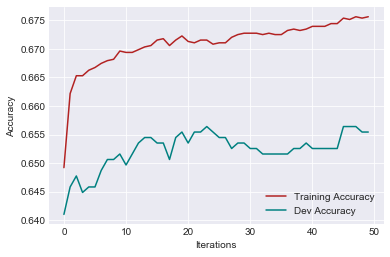

Train Accuracy: 0.6756431834575619
Dev Accuracy: 0.6554379210779596


In [8]:
print('lr = 1E-7')
model_lr_1e7 = QuadraticRegression(step_size = 1e-7, max_iter = 50)
x_lr_1e7, y_lr_1e7= model_lr_1e7.process_data(teams_train, dates_train, results_train)
dev_x_1e7, dev_y_1e7 = model_lr_1e7.process_data(teams_dev, dates_dev, results_dev)
model_lr_1e7.fit(x_lr_1e7, y_lr_1e7, dev_x_1e7, dev_y_1e7)

train_accuracy_1e7 = model_lr_1e7.general_predict(teams_train, dates_train, results_train)
dev_accuracy_1e7 = model_lr_1e7.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_1e7))
print('Dev Accuracy: {}'.format(dev_accuracy_1e7))

np.savetxt('full_dataset_lr_1e7.txt', np.array(model_lr_1e7.error_list), delimiter =',')
np.savetxt('training_acc_lr_1e7.txt', np.array(model_lr_1e7.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_1e7.txt', np.array(model_lr_1e7.dev_acc), delimiter =',')

In [9]:
# Individual season analysis -- best learning rate is 2E-6 (determined by previous experiments in quadratic_classifier_torch.ipynb)
n_train_s = 983
n_dev_s = 1229

In [46]:
# 2014-2015 Season
teams_2014, dates_2014, results_2014 = shuffle(teams_all[0:1229], dates_all[0:1229], results_all[0:1229], random_state=1)

teams_train_2014 = teams_2014[0:n_train_s]
dates_train_2014 = dates_2014[0:n_train_s]
results_train_2014 = results_2014[0:n_train_s]

teams_dev_2014 = teams_2014[n_train_s + 1:n_dev_s]
dates_dev_2014 = dates_2014[n_train_s + 1:n_dev_s]
results_dev_2014 = results_2014[n_train_s + 1:n_dev_s]

print('Season: 2014-2015')
model_2014 = QuadraticRegression(step_size = 2e-6, max_iter = 50)
x_2014, y_2014 = model_2014.process_data(teams_train_2014, dates_train_2014, results_train_2014)
dev_x_2014, dev_y_2014 = model_2014.process_data(teams_dev_2014, dates_dev_2014, results_dev_2014)
model_2014.fit(x_2014, y_2014, dev_x_2014, dev_y_2014)

train_accuracy_2014 = model_2014.general_predict(teams_train_2014, dates_train_2014, results_train_2014)
dev_accuracy_2014 = model_2014.general_predict(teams_dev_2014, dates_dev_2014, results_dev_2014)
test_accuracy_2014 = model_2014.playoff_prediction('data_sets/2015_playoffs.csv', '2015-04-10')

print('Train Accuracy: {}'.format(train_accuracy_2014))
print('Dev Accuracy: {}'.format(dev_accuracy_2014))
print('Playoff Accuracy: {}'.format(test_accuracy_2014))

np.savetxt('error_2014.txt', np.array(model_2014.error_list), delimiter =',')
np.savetxt('training_acc_2014.txt', np.array(model_2014.training_acc), delimiter =',')
np.savetxt('dev_acc_2014.txt', np.array(model_2014.dev_acc), delimiter =',')

Season: 2014-2015
Error 1: 0.2967360986582312
Training Accuracy: 0.6439471007121058
Dev Accuracy: 0.5714285714285714
Error 2: 0.28654847579362247
Training Accuracy: 0.6683621566632757
Dev Accuracy: 0.5673469387755102
Error 3: 0.27677707953187725
Training Accuracy: 0.669379450661241
Dev Accuracy: 0.5795918367346938
Error 4: 0.2681788560194904
Training Accuracy: 0.671414038657172
Dev Accuracy: 0.5795918367346938
Error 5: 0.26060440185211975
Training Accuracy: 0.6744659206510681
Dev Accuracy: 0.5795918367346938
Error 6: 0.2539175874084434
Training Accuracy: 0.6785350966429298
Dev Accuracy: 0.5795918367346938
Error 7: 0.2479980339242168
Training Accuracy: 0.676500508646999
Dev Accuracy: 0.5836734693877551
Error 8: 0.24274121883919655
Training Accuracy: 0.6795523906408952
Dev Accuracy: 0.5795918367346938
Error 9: 0.2380573683151696
Training Accuracy: 0.6795523906408952
Dev Accuracy: 0.5836734693877551
Error 10: 0.23386983745561735
Training Accuracy: 0.6795523906408952
Dev Accuracy: 0.583673

KeyboardInterrupt: 

In [45]:
# Model trained on 2014-2015 data, tested on 2015-2016 data
dev_accuracy_2014 = model_2014.general_predict(teams_dev_2014, dates_dev_2014, results_dev_2014)
print(dev_accuracy_2014)
teams_2015, dates_2015, results_2015 = shuffle(teams_all[1230:2459], dates_all[1230:2459], results_all[1230:2459], random_state=1)
test_accuracy_14m_15 = model_2014.general_predict(teams_2015, dates_2015, results_2015)
print(test_accuracy_14m_15)

0.5959183673469388
0.6265256305939788


Training: 2014-2015, 2015-2016 Season
Error 1: 0.48912192843056973
Training Accuracy: 0.6476868327402135
Dev Accuracy: 0.6069246435845214
Error 2: 0.4504582072944231
Training Accuracy: 0.6583629893238434
Dev Accuracy: 0.6211812627291242
Error 3: 0.41991055964805496
Training Accuracy: 0.6537874936451449
Dev Accuracy: 0.6313645621181263
Error 4: 0.3960096362392556
Training Accuracy: 0.6598881545500762
Dev Accuracy: 0.6313645621181263
Error 5: 0.3771528676631576
Training Accuracy: 0.6629384850025419
Dev Accuracy: 0.6354378818737271
Error 6: 0.36212045013059757
Training Accuracy: 0.6639552618200305
Dev Accuracy: 0.639511201629328
Error 7: 0.35000838256548455
Training Accuracy: 0.6614133197763091
Dev Accuracy: 0.6293279022403259
Error 8: 0.3401497818647002
Training Accuracy: 0.6614133197763091
Dev Accuracy: 0.6252545824847251
Error 9: 0.3320499136939795
Training Accuracy: 0.6644636502287747
Dev Accuracy: 0.6272912423625254
Error 10: 0.3253380058380905
Training Accuracy: 0.6659888154550077
D

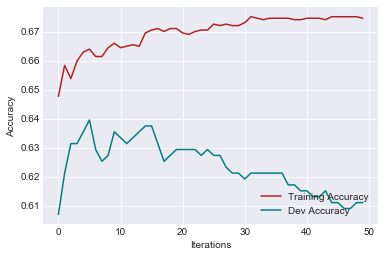

Train Accuracy: 0.6746314184036604
Dev Accuracy: 0.6109979633401222
Test Accuracy: 0.676159479251424


In [47]:
# Training: 2014-2015, 2015-2016 Season, Testing: 2016-2017 season
teams_2015, dates_2015, results_2015 = shuffle(teams_all[0:2459], dates_all[0:2459], results_all[0:2459], random_state=1)

teams_train_2015 = teams_2015[0:1967]
dates_train_2015 = dates_2015[0:1967]
results_train_2015 = results_2015[0:1967]

teams_dev_2015 = teams_2015[1968:2459]
dates_dev_2015 = dates_2015[1968:2459]
results_dev_2015 = results_2015[1968:2459]

print('Training: 2014-2015, 2015-2016 Season')
model_2015 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_2015, y_2015 = model_2015.process_data(teams_train_2015, dates_train_2015, results_train_2015)
dev_x_2015, dev_y_2015 = model_2015.process_data(teams_dev_2015, dates_dev_2015, results_dev_2015)
model_2015.fit(x_2015, y_2015, dev_x_2015, dev_y_2015)

train_accuracy_2015 = model_2015.general_predict(teams_train_2015, dates_train_2015, results_train_2015)
dev_accuracy_2015 = model_2015.general_predict(teams_dev_2015, dates_dev_2015, results_dev_2015)
test_accuracy_2015 = model_2015.general_predict(teams_all[2460:3689], dates_all[2460:3689], results_all[2460:3689])

print('Train Accuracy: {}'.format(train_accuracy_2015))
print('Dev Accuracy: {}'.format(dev_accuracy_2015))
print('Test Accuracy: {}'.format(test_accuracy_2015))

Training: 2014-2015, 2015-2016, 2016-2017 season, Testing: 2017-2018 season
Error 1: 1.071828842111611
Training Accuracy: 0.6529989833954591
Dev Accuracy: 0.6404341926729986
Error 2: 0.8931140203569393
Training Accuracy: 0.6631650288037954
Dev Accuracy: 0.6458616010854816
Error 3: 0.7893810280159217
Training Accuracy: 0.6709589969501863
Dev Accuracy: 0.6472184531886025
Error 4: 0.7298576909716713
Training Accuracy: 0.6740088105726872
Dev Accuracy: 0.6512890094979648
Error 5: 0.6933273623918135
Training Accuracy: 0.6757031514740766
Dev Accuracy: 0.6445047489823609
Error 6: 0.6697272078985286
Training Accuracy: 0.6760420196543545
Dev Accuracy: 0.6377204884667571
Error 7: 0.653856886765316
Training Accuracy: 0.677397492375466
Dev Accuracy: 0.6363636363636364
Error 8: 0.6428229131423693
Training Accuracy: 0.6797695696374111
Dev Accuracy: 0.6363636363636364
Error 9: 0.6349243051541144
Training Accuracy: 0.6804473059979668
Dev Accuracy: 0.6377204884667571
Error 10: 0.62911954460728
Training 

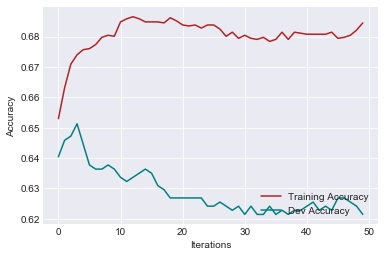

Train Accuracy: 0.6845137241613013
Dev Accuracy: 0.621438263229308
Test Accuracy: 0.6737184703010578


In [48]:
# Training: 2014-2015, 2015-2016, 2016-2017 season, Testing: 2017-2018 season
teams_2016, dates_2016, results_2016 = shuffle(teams_all[0:3689], dates_all[0:3689], results_all[0:3689], random_state=1)

teams_train_2016 = teams_2016[0:2951]
dates_train_2016 = dates_2016[0:2951]
results_train_2016 = results_2016[0:2951]

teams_dev_2016 = teams_2016[2952:3689]
dates_dev_2016 = dates_2016[2952:3689]
results_dev_2016 = results_2016[2952:3689]

print('Training: 2014-2015, 2015-2016, 2016-2017 season, Testing: 2017-2018 season')
model_2016 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_2016, y_2016 = model_2016.process_data(teams_train_2016, dates_train_2016, results_train_2016)
dev_x_2016, dev_y_2016 = model_2016.process_data(teams_dev_2016, dates_dev_2016, results_dev_2016)
model_2016.fit(x_2016, y_2016, dev_x_2016, dev_y_2016)

train_accuracy_2016 = model_2016.general_predict(teams_train_2016, dates_train_2016, results_train_2016)
dev_accuracy_2016 = model_2016.general_predict(teams_dev_2016, dates_dev_2016, results_dev_2016)
test_accuracy_2016 = model_2016.general_predict(teams_all[3690:4919], dates_all[3690:4919], results_all[3690:4919])

print('Train Accuracy: {}'.format(train_accuracy_2016))
print('Dev Accuracy: {}'.format(dev_accuracy_2016))
print('Test Accuracy: {}'.format(test_accuracy_2016))

Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018 season, Testing: 2018-2019 season
Error 1: 1.9622147397514325
Training Accuracy: 0.6449809402795426
Dev Accuracy: 0.6174974567650051
Error 2: 1.4234778191043607
Training Accuracy: 0.6660736975857687
Dev Accuracy: 0.6480162767039674
Error 3: 1.2617030287657314
Training Accuracy: 0.6742058449809403
Dev Accuracy: 0.6561546286876907
Error 4: 1.1527299779990354
Training Accuracy: 0.6762388818297331
Dev Accuracy: 0.6541200406917599
Error 5: 1.207643886025204
Training Accuracy: 0.6762388818297331
Dev Accuracy: 0.6541200406917599
Error 6: 1.1461064612784144
Training Accuracy: 0.6762388818297331
Dev Accuracy: 0.6510681586978637
Error 7: 1.178551523942093
Training Accuracy: 0.680559085133418
Dev Accuracy: 0.6541200406917599
Error 8: 1.1420447695712772
Training Accuracy: 0.680304955527319
Dev Accuracy: 0.659206510681587
Error 9: 1.1416643232871877
Training Accuracy: 0.6810673443456162
Dev Accuracy: 0.6531027466937945
Error 10: 1.160709761865659

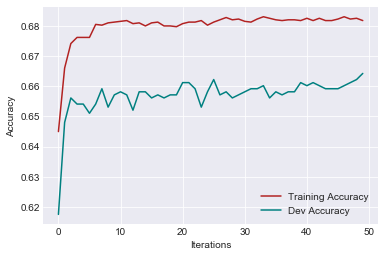

Train Accuracy: 0.6818297331639136
Dev Accuracy: 0.6642929806714141
Test Accuracy: 0.5915378356387306


In [49]:
# Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018 season, Testing: 2018-2019 season
teams_2017, dates_2017, results_2017 = shuffle(teams_all[0:4919], dates_all[0:4919], results_all[0:4919], random_state=1)

teams_train_2017 = teams_2017[0:3935]
dates_train_2017 = dates_2017[0:3935]
results_train_2017 = results_2017[0:3935]

teams_dev_2017 = teams_2017[3936:4919]
dates_dev_2017 = dates_2017[3936:4919]
results_dev_2017 = results_2017[3936:4919]

print('Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018 season, Testing: 2018-2019 season')
model_2017 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_2017, y_2017 = model_2017.process_data(teams_train_2017, dates_train_2017, results_train_2017)
dev_x_2017, dev_y_2017 = model_2017.process_data(teams_dev_2017, dates_dev_2017, results_dev_2017)
model_2017.fit(x_2017, y_2017, dev_x_2017, dev_y_2017)

train_accuracy_2017 = model_2017.general_predict(teams_train_2017, dates_train_2017, results_train_2017)
dev_accuracy_2017 = model_2017.general_predict(teams_dev_2017, dates_dev_2017, results_dev_2017)
test_accuracy_2017 = model_2017.general_predict(teams_all[4920:6149], dates_all[4920:6149], results_all[4920:6149])

print('Train Accuracy: {}'.format(train_accuracy_2017))
print('Dev Accuracy: {}'.format(dev_accuracy_2017))
print('Test Accuracy: {}'.format(test_accuracy_2017))

Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018, 2018-2019 seasons, Testing: 2019-2020 season
Error 1: 2.78011156221948
Training Accuracy: 0.6499288473266924
Dev Accuracy: 0.6240846216436127
Error 2: 1.8439596048039322
Training Accuracy: 0.6739174628989631
Dev Accuracy: 0.6371033360455655
Error 3: 1.724450705613693
Training Accuracy: 0.6804228501727994
Dev Accuracy: 0.6403580146460537
Error 4: 1.6069487056608953
Training Accuracy: 0.6779833299451108
Dev Accuracy: 0.6371033360455655
Error 5: 1.6904938555881355
Training Accuracy: 0.6828623704004879
Dev Accuracy: 0.6371033360455655
Error 6: 1.594775438558498
Training Accuracy: 0.6826590770481805
Dev Accuracy: 0.6346623270951993
Error 7: 1.6424573558516382
Training Accuracy: 0.681845903638951
Dev Accuracy: 0.6379170056956875
Error 8: 1.6401481424831472
Training Accuracy: 0.6830656637527953
Dev Accuracy: 0.6371033360455655
Error 9: 1.6162736442910632
Training Accuracy: 0.6863183573897134
Dev Accuracy: 0.6330349877949553
Error 10: 1.604

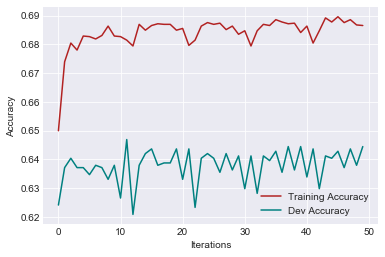

Train Accuracy: 0.6865216507420208
Dev Accuracy: 0.644426362896664
Playoff Accuracy: 0.6371428571428571


In [50]:
# Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018, 2018-2019 seasons, Testing: 2019-2020 season
teams_2018, dates_2018, results_2018 = shuffle(teams_all[0:6149], dates_all[0:6149], results_all[0:6149], random_state=1)

teams_train_2018 = teams_2018[0:4919]
dates_train_2018 = dates_2018[0:4919]
results_train_2018 = results_2018[0:4919]

teams_dev_2018 = teams_2018[4920:6149]
dates_dev_2018 = dates_2018[4920:6149]
results_dev_2018 = results_2018[4920:6149]

print('Training: 2014-2015, 2015-2016, 2016-2017, 2017-2018, 2018-2019 seasons, Testing: 2019-2020 season')
model_2018 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_2018, y_2018 = model_2018.process_data(teams_train_2018, dates_train_2018, results_train_2018)
dev_x_2018, dev_y_2018 = model_2018.process_data(teams_dev_2018, dates_dev_2018, results_dev_2018)
model_2018.fit(x_2018, y_2018, dev_x_2018, dev_y_2018)

train_accuracy_2018 = model_2018.general_predict(teams_train_2018, dates_train_2018, results_train_2018)
dev_accuracy_2018 = model_2018.general_predict(teams_dev_2018, dates_dev_2018, results_dev_2018)
test_accuracy_2018 = model_2018.general_predict(teams_all[6150:6500], dates_all[6150:6500], results_all[6150:6500])

print('Train Accuracy: {}'.format(train_accuracy_2018))
print('Dev Accuracy: {}'.format(dev_accuracy_2018))
print('Playoff Accuracy: {}'.format(test_accuracy_2018))

lr = 1E-6 with whole dataset (including current season)
Error 1: 1.9347533588799954
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 1.5072285574969846
Training Accuracy: 0.6660254868958885
Dev Accuracy: 0.6448508180943214
Error 3: 1.351626390269939
Training Accuracy: 0.6739600865592691
Dev Accuracy: 0.6525505293551492
Error 4: 1.233233865310115
Training Accuracy: 0.6737196441452272
Dev Accuracy: 0.6544754571703562
Error 5: 1.2848972235661786
Training Accuracy: 0.677085837941813
Dev Accuracy: 0.6564003849855631
Error 6: 1.222304482135643
Training Accuracy: 0.678528492426064
Dev Accuracy: 0.6573628488931665
Error 7: 1.2509561332698806
Training Accuracy: 0.679971146910315
Dev Accuracy: 0.6602502406159769
Error 8: 1.2152547868327925
Training Accuracy: 0.6826160134647752
Dev Accuracy: 0.6641000962463908
Error 9: 1.2325270614925572
Training Accuracy: 0.6821351286366916
Dev Accuracy: 0.6641000962463908
Error 10: 1.210625161592522
Training Accuracy: 0.6859822072

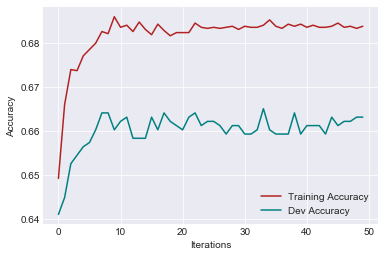

Train Accuracy: 0.6838182255349844
Dev Accuracy: 0.6631376323387873


In [35]:
print('lr = 1E-6 with whole dataset (including current season)')
model_lr_1e6 = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_lr_1e6, y_lr_1e6= model_lr_1e6.process_data(teams_train, dates_train, results_train)
dev_x_1e6, dev_y_1e6 = model_lr_1e6.process_data(teams_dev, dates_dev, results_dev)
model_lr_1e6.fit(x_lr_1e6, y_lr_1e6, dev_x_1e6, dev_y_1e6)

train_accuracy_1e6 = model_lr_1e6.general_predict(teams_train, dates_train, results_train)
dev_accuracy_1e6 = model_lr_1e6.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_1e6))
print('Dev Accuracy: {}'.format(dev_accuracy_1e6))

np.savetxt('full_dataset_lr_1e6.txt', np.array(model_lr_1e6.error_list), delimiter =',')
np.savetxt('training_acc_lr_1e6.txt', np.array(model_lr_1e6.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_1e6.txt', np.array(model_lr_1e6.dev_acc), delimiter =',')

lr = 1E-6 with whole dataset (including current season)
Error 1: 1.9347533588799954
Training Accuracy: 0.6491945179129599
Dev Accuracy: 0.6410009624639076
Error 2: 1.5072285574969846
Training Accuracy: 0.6660254868958885
Dev Accuracy: 0.6448508180943214
Error 3: 1.351626390269939
Training Accuracy: 0.6739600865592691
Dev Accuracy: 0.6525505293551492
Error 4: 1.233233865310115
Training Accuracy: 0.6737196441452272
Dev Accuracy: 0.6544754571703562
Error 5: 1.2848972235661786
Training Accuracy: 0.677085837941813
Dev Accuracy: 0.6564003849855631
Error 6: 1.222304482135643
Training Accuracy: 0.678528492426064
Dev Accuracy: 0.6573628488931665
Error 7: 1.2509561332698806
Training Accuracy: 0.679971146910315
Dev Accuracy: 0.6602502406159769
Error 8: 1.2152547868327925
Training Accuracy: 0.6826160134647752
Dev Accuracy: 0.6641000962463908
Error 9: 1.2325270614925572
Training Accuracy: 0.6821351286366916
Dev Accuracy: 0.6641000962463908
Error 10: 1.210625161592522
Training Accuracy: 0.6859822072

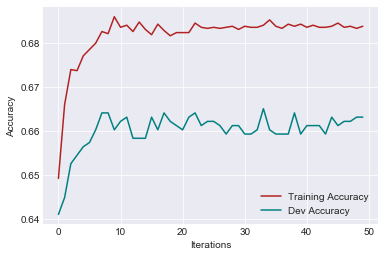

Train Accuracy: 0.6838182255349844
Dev Accuracy: 0.6631376323387873


In [76]:
teams_s, dates_s, results_s = shuffle(teams_all, dates_all, results_all, random_state=0)
# 64% training, 16% dev, 20% test
n_train = 4159
n_dev = 5199
n_full = 6500

teams_train = teams_s[0:n_train]
dates_train = dates_s[0:n_train]
results_train = results_s[0:n_train]

teams_dev = teams_s[n_train + 1:n_dev]
dates_dev = dates_s[n_train + 1:n_dev]
results_dev = results_s[n_train + 1:n_dev]

teams_test = teams_s[n_dev + 1:n_full]
dates_test = dates_s[n_dev + 1:n_full]
results_test = results_s[n_dev + 1:n_full]

print('lr = 1E-6 with whole dataset (including current season)')
model_final = QuadraticRegression(step_size = 1e-6, max_iter = 50)
x_train_final, y_train_final = model_final.process_data(teams_train, dates_train, results_train)
dev_x_final, dev_y_final = model_final.process_data(teams_dev, dates_dev, results_dev)
model_final.fit(x_train_final, y_train_final, dev_x_final, dev_y_final)

train_accuracy_1e6 = model_final.general_predict(teams_train, dates_train, results_train)
dev_accuracy_1e6 = model_final.general_predict(teams_dev, dates_dev, results_dev)

print('Train Accuracy: {}'.format(train_accuracy_1e6))
print('Dev Accuracy: {}'.format(dev_accuracy_1e6))

np.savetxt('full_dataset_lr_1e6.txt', np.array(model_final.error_list), delimiter =',')
np.savetxt('training_acc_lr_1e6.txt', np.array(model_final.training_acc), delimiter =',')
np.savetxt('dev_acc_lr_1e6.txt', np.array(model_final.dev_acc), delimiter =',')

In [40]:
test_accuracy_1e6 = model_lr_1e6.general_predict(teams_test, dates_test, results_test)
print(test_accuracy_1e6)

0.6507692307692308


True
True
True
True


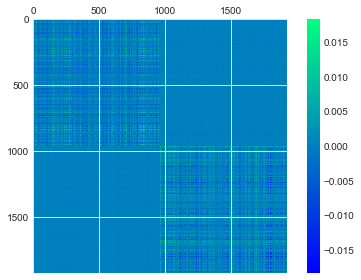

In [41]:
fig, ax = plt.subplots()
S, S2, A, A2 = model_lr_1e6.getSAS()

# Check for symmetry
print(np.allclose(S, S.T, 1e-10, 1e-10))
print(np.allclose(-1*S, S2, 1e-10, 1e-10))
print(np.allclose(-1*A, A.T, 1e-10, 1e-10))
print(np.allclose(A2.T, -1*A2, 1e-10, 1e-10))

# Plot matrix
im = ax.matshow(model_lr_1e6.theta, cmap = 'winter')
cbar = fig.colorbar(im)

fig.tight_layout()
plt.show()

In [42]:
def chemistry(player1, player2, S, A):
    player1_ind = player_index[player1]
    player2_ind = player_index[player2]
    
    chem_s = S[player1_ind, player2_ind]
    chem_a = A[player1_ind, player2_ind]
    player1_skill = S[player1_ind, player1_ind]
    player2_skill = S[player2_ind, player2_ind]
    
    return chem_s, chem_a, player1_skill, player2_skill
    
print(chemistry('LeBron James','Kyrie Irving', model_lr_1e6))
print(chemistry('Kevin Durant','Stephen Curry', model_lr_1e6))

(0.00817647480932095, 1.514576653872501e-05, 0.0112151217582617, 0.004370085664213701)
(0.0047122490468239, 0.0008036555994989215, 0.004842051022295421, 0.00645945621933675)


In [56]:
S, S2, A, A2 = model_lr_1e6.getSAS()
print(np.amax(S))
print(np.amin(S))
print(np.amax(A))
print(np.amin(A))

0.01492162608336026
-0.018316090993956417
0.002785792638504479
-0.002785792638504479


In [57]:
S_nor = S/np.amax(S)
A_nor = A/np.amax(A)

In [58]:
def chemistry(player1, player2, S, A):
    player1_ind = player_index[player1]
    player2_ind = player_index[player2]
    
    chem_s = S[player1_ind, player2_ind]
    chem_a = A[player1_ind, player2_ind]
    player1_skill = S[player1_ind, player1_ind]
    player2_skill = S[player2_ind, player2_ind]
    
    return chem_s, chem_a, player1_skill, player2_skill

print(chemistry('LeBron James','Kyrie Irving', S_nor, A_nor))
print(chemistry('Kevin Durant','Stephen Curry', S_nor, A_nor))

(0.5479613792520163, 0.005436788915795198, 0.7516018492628065, 0.2928692650385449)
(0.31579996848190217, 0.2884836395900432, 0.32449888472242294, 0.4328922453391299)


In [59]:
S_nor_2 = S/(np.amax(S)-np.amin(S))
A_nor_2 = A/(np.amax(A)-np.amin(A))

In [70]:
print(chemistry('LeBron James','Kyrie Irving', S_nor_2, A_nor_2))
print(chemistry('Kevin Durant','Stephen Curry', S_nor_2, A_nor_2))
print(chemistry('LeBron James','Al Horford', S_nor_2, A_nor_2))
print(chemistry('LeBron James','Danny Green', S_nor_2, A_nor_2))

(0.2459998919390599, 0.002718394457897599, 0.3374215422850308, 0.13147971787737783)
(0.14177414880397451, 0.1442418197950216, 0.14567941026250306, 0.19434115177979694)
(0.3555514150558338, 0.05406000190523327, 0.3374215422850308, 0.4001038935063611)
(0.3808454592541845, 0.0173267426212916, 0.3374215422850308, 0.420997667630948)


In [63]:
print(player_index['Stephen Curry'])
print(player_index['LeBron James'])

679
397


In [74]:
np.argmax(S[397, :])

24

In [65]:
personal = np.diagonal(S)

ind = np.where(personal == np.amax(personal))[0]
for i in player_index:
    if player_index[i] == ind:
        print(i)
        break;

Danny Green


In [66]:
S_final, S2_final, A_final, A2_final = model_final.getSAS()

In [67]:
personal = np.diagonal(S)

ind = np.where(personal == np.amax(personal))[0]
for i in player_index:
    if player_index[i] == ind:
        print(i)
        break;

Danny Green


In [75]:
list(all_players)[24]

'Danny Green'